# Authentication Establishment

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.0MB/s 


# Importing the Clear Data 

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
    100% |████████████████████████████████| 697.2MB 22kB/s 
1.0.0.dev20190322
True
True
    100% |████████████████████████████████| 17.3MB 2.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


## Taking the clean images which we saved in Google Drive in Earlier Notebook

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id_ = ""

downloaded = drive.CreateFile({'id':id_}) 
downloaded.GetContentFile('train.zip')   

### Unzipping the train.zip

In [0]:
%%capture
!unzip train.zip

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

#### Creating a Validation folder from the Given Training Data

In [0]:
!mkdir tmp/val
!mkdir tmp/val/0
!mkdir tmp/val/1
!mkdir tmp/val/2
!mkdir tmp/val/3
!mkdir tmp/val/4

In [0]:
BASE_DIR = "tmp/train/"
NEW_DIR= "tmp/val/"

list_dir =  os.listdir(BASE_DIR)

for tdir in list_dir:
    list_images = os.listdir(BASE_DIR+tdir)
    to_val = random.sample(list_images, len(list_images)//5)
    for images in to_val:
        os.rename(BASE_DIR + str(tdir) + "/"+ images, NEW_DIR + str(tdir) + "/" + images )

# Making Machine Learning Model

In [0]:
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch =   densenet201                 # specify model architecture, densenet169 seems to perform well for this data but you could experiment
bs = 10 # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = 512                      # input size is the crop size
#MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

In [0]:
PATH ='./tmp/'
tfms = get_transforms(do_flip=True,max_zoom=1.3)

data = ImageDataBunch.from_folder('./tmp',ds_tfms = tfms, valid='val', size=sz,bs=bs)

In [0]:
data = data.normalize(imagenet_stats)

In [ ]:
def getLearner():
    return cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.2, callback_fns=ShowGraph)

learner = getLearner()

### Model Architecture 

In [0]:
from torchsummary import summary
summary(learner.model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]           8,192
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]          36,864
      BatchNorm2d-11         [-1, 96, 128, 128]             192
             ReLU-12         [-1, 96, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]          12,288
      BatchNorm2d-14        [-1, 128, 1

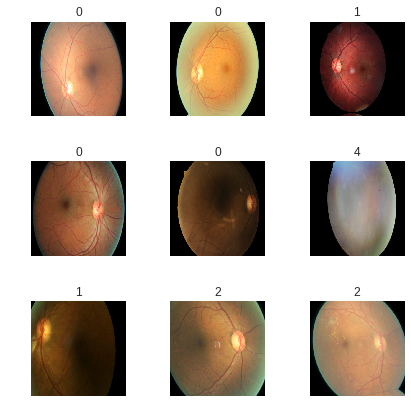

In [0]:
data.show_batch(rows=3, figsize=(6,6));

### Taking learning rate for the previous notebook

In [0]:
max_lr = 1e-3
wd = 1e-6

### Fitting the Model

epoch,train_loss,valid_loss,accuracy,time
0,1.104533,1.052842,0.621869,45:09
1,0.920231,0.866202,0.673997,44:55
2,0.803812,0.777084,0.705559,45:03
3,0.764604,0.704630,0.733455,44:49
4,0.691905,0.677392,0.743637,44:47
5,0.680551,0.648187,0.755447,44:52
6,0.599412,0.619531,0.768275,44:48


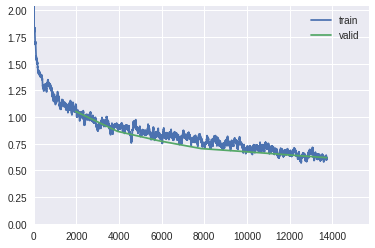

Buffered data was truncated after reaching the output size limit.

In [0]:
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.757510,0.728719,0.730605,57:43
1,0.741443,0.660608,0.751578,57:34
2,0.683744,0.601534,0.767461,57:44
3,0.596244,0.591047,0.772551,57:55


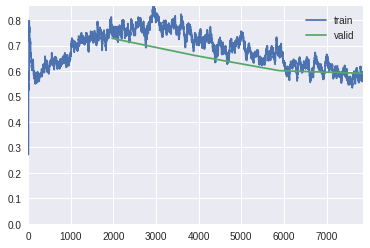

In [0]:
max_lr =3e-4
max_lrs = [max_lr/9,max_lr/3,max_lr]
wds = [wd/9,wd/3,wd]
wd = 1e-6
learner.unfreeze()
learner.fit_one_cycle(cyc_len=4, max_lr=max_lrs, wd=wds)

epoch,train_loss,valid_loss,accuracy,time
0,0.563727,0.533711,0.794339,56:48
1,0.590286,0.514370,0.804724,56:09
2,0.536467,0.500096,0.811647,56:23
3,0.490264,0.494299,0.813480,56:29


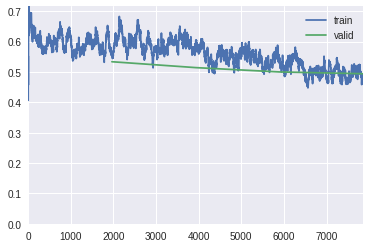

In [0]:
max_lr =1e-4
max_lrs = [max_lr/9,max_lr/3,max_lr]
wds = [wd/9,wd/3,wd]
wd = 1e-6
learner.unfreeze()
learner.fit_one_cycle(cyc_len=4, max_lr=max_lrs, wd=wds)

### Plotting the Confusion Matrix 

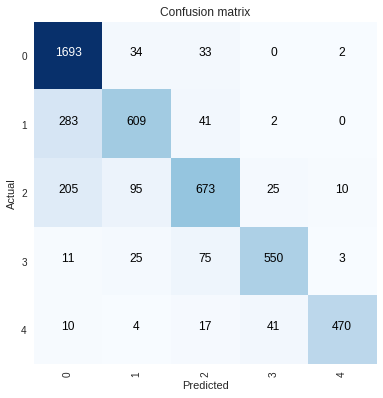

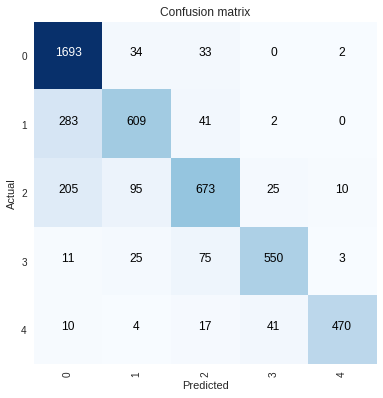

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = data.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = data.one_item(tensorImg)
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [0]:
from random import randint

def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

### Plotting the Results

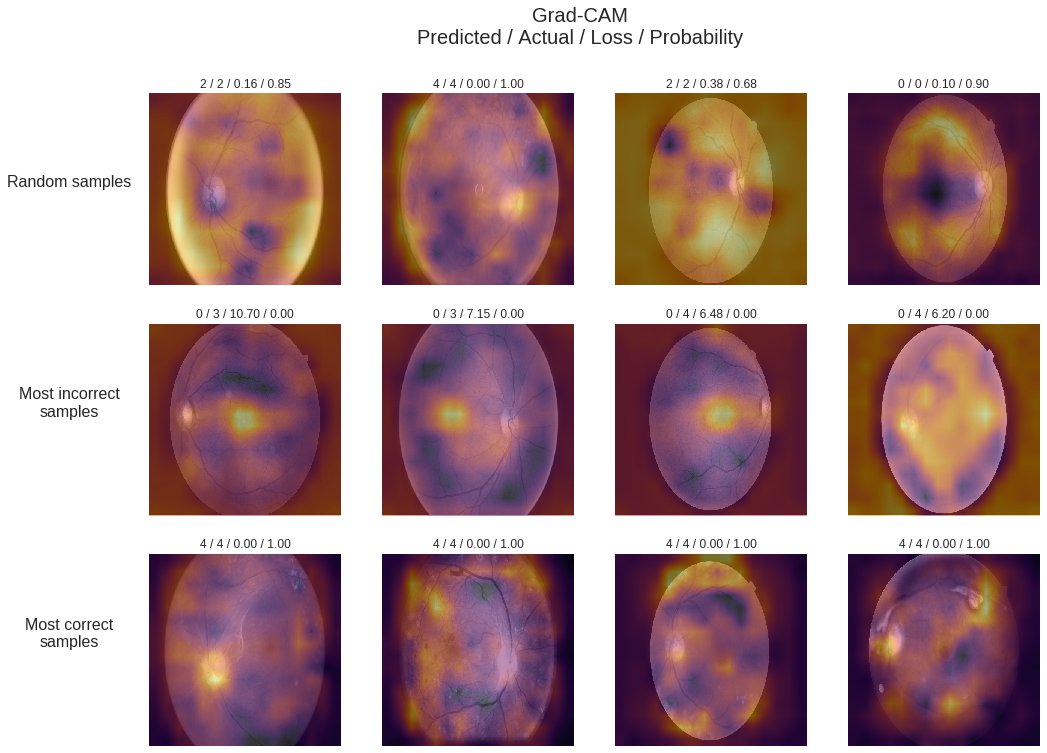

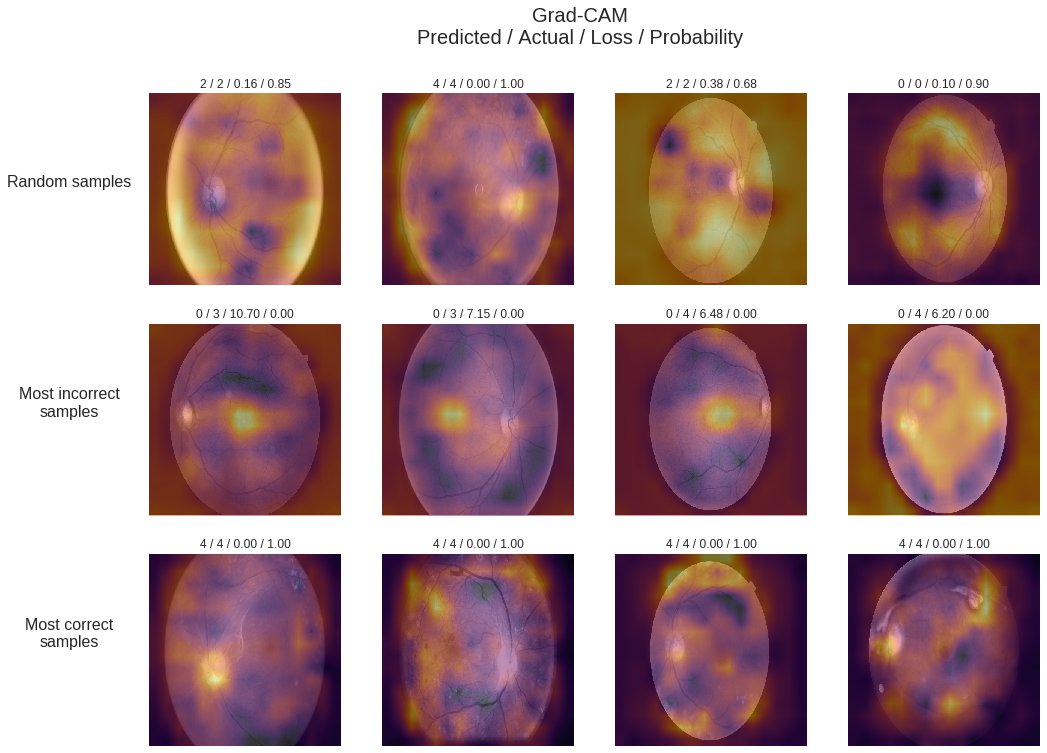

In [0]:
plot_heatmap_overview(interp, ['0','1','2','3','4'])

In [0]:
learner.save('DR')